### Setup and Imports

In [122]:
import duckdb
import pandas as pd
from pathlib import Path

def run_query(sql_query: str) -> pd.DataFrame:
    """
    Connects to the dbt warehouse, runs a SQL query,
    prints the results beautifully, and returns a DataFrame.
    """
    db_path = Path('../data_lake/prod.duckdb')
    df = pd.DataFrame() # Initialize an empty DataFrame
    try:
        with duckdb.connect(database=str(db_path), read_only=True) as con:
            df = con.execute(sql_query).df()
    except Exception as e:
        print(f"An error occurred: {e}")
    return df

print("Helper function `run_query` is defined.")

Helper function `run_query` is defined.


### List Available Models

In [123]:
print("\n--- Available Tables/Models in 'main' schema ---")
run_query("SHOW TABLES")


--- Available Tables/Models in 'main' schema ---


,name
0,agg_customer_daily_balance_180d
1,all_transactions_by_customer
2,dim_calendar
3,fct_daily_transactions_by_customer
4,statements


### Load the all_transactions_by_customer Model

In [42]:
print("\n--- Loading 'all_transactions_by_customer' model ---")
transactions_df = run_query("SELECT * FROM main.all_transactions_by_customer")
print("Schema:")
transactions_df.info()
print("\nFirst 5 rows:")
transactions_df.head()


--- Loading 'all_transactions_by_customer' model ---
Schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   username                                   1217 non-null   object        
 1   email                                      1217 non-null   object        
 2   address                                    1217 non-null   object        
 3   financial_institution                      1217 non-null   object        
 4   employer_name                              1217 non-null   object        
 5   login_id                                   1217 non-null   object        
 6   request_id                                 1217 non-null   object        
 7   request_datetime                           1217 non-null   object        
 8   request_status                      

,username,email,address,financial_institution,employer_name,login_id,request_id,request_datetime,request_status,days_detected,...,date,description,category,subcategory,withdrawals,deposits,balance,most_recent_statement_date,most_recent_statement_date_minus_90_days,most_recent_statement_date_minus_180_days
0,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,"36 HOLKHAM AVE, ANCASTER, ON, L9K1P1",Simplii,,5eff116b-d0d9-4924-4b37-08dc29c779f9,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,Get Statements Completed,,...,2024-02-08,NSF FEE NSF S/C,debit,,45.00,NaN,1482.55,2024-02-09,2023-11-11,2023-08-13
1,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,"36 HOLKHAM AVE, ANCASTER, ON, L9K1P1",Simplii,,5eff116b-d0d9-4924-4b37-08dc29c779f9,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,Get Statements Completed,,...,2023-03-29,POS MERCHANDISE AIR-SERV MAC S/,debit,,2.00,NaN,3043.40,2024-02-09,2023-11-11,2023-08-13
2,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,"36 HOLKHAM AVE, ANCASTER, ON, L9K1P1",Simplii,,5eff116b-d0d9-4924-4b37-08dc29c779f9,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,Get Statements Completed,,...,2023-10-18,POS MERCHANDISE DOLLARAMA 898,debit,,5.34,NaN,4939.63,2024-02-09,2023-11-11,2023-08-13
3,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,"36 HOLKHAM AVE, ANCASTER, ON, L9K1P1",Simplii,,5eff116b-d0d9-4924-4b37-08dc29c779f9,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,Get Statements Completed,,...,2023-10-18,POS MERCHANDISE FRESHCO 9825,debit,,11.80,NaN,4944.97,2024-02-09,2023-11-11,2023-08-13
4,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,"36 HOLKHAM AVE, ANCASTER, ON, L9K1P1",Simplii,,5eff116b-d0d9-4924-4b37-08dc29c779f9,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,Get Statements Completed,,...,2024-02-06,INTERAC E-TRANSFER SEND Jason Schaubel,debit,,50.00,NaN,1727.55,2024-02-09,2023-11-11,2023-08-13


### Model Development

Copy and paste the query below according to your development needs.

#### Average Daily Balance - Logic

In [129]:
query = """
    WITH filtered_daily_transactions AS (
        SELECT
            username,
            email,
            request_id,
            request_datetime,
            date,
            withdrawals,
            deposits,
            balance,
            most_recent_statement_date_minus_180_days AS start_date,
            most_recent_statement_date AS end_date
        FROM main.all_transactions_by_customer
        WHERE date >= most_recent_statement_date_minus_180_days AND date <= most_recent_statement_date
    )

    ,dim_calendar AS (
        SELECT *
        FROM main.dim_calendar
    )

    ,customer_date_range AS (
        SELECT
            email,
            request_id,
            start_date,
            end_date
        FROM filtered_daily_transactions
        GROUP BY ALL
    )

    ,customer_scaffold AS (
        SELECT
            cdr.email,
            cdr.request_id,
            cal.date_day as date
        FROM customer_date_range AS cdr
        CROSS JOIN dim_calendar AS cal
        WHERE cal.date_day > cdr.start_date
          AND cal.date_day <= cdr.end_date
        ORDER By date DESC
    )

    ,padded_transactions AS (
        SELECT
            scf.email,
            scf.request_id,
            scf.date,
            trn.withdrawals,
            trn.deposits,
            trn.balance,
            ROUND(AVG(trn.balance) OVER(PARTITION BY scf.email, scf.request_id, scf.date), 2) AS average_balance
        FROM customer_scaffold AS scf
        LEFT JOIN filtered_daily_transactions AS trn ON scf.email = trn.email
            AND scf.request_id = trn.request_id
            AND scf.date = trn.date
/*        WHERE scf.date >= '2024-02-02' AND scf.date <= '2024-02-05'*/
    )

    ,daily_balances AS (
        SELECT
            email,
            request_id,
            date,
            LAST_VALUE(average_balance IGNORE NULLS) OVER(
                PARTITION BY email, request_id
                ORDER BY date
                ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
            ) AS revised_average_balance
        FROM padded_transactions
    )
    
    SELECT *
    FROM daily_balances
    GROUP BY ALL
    ORDER BY date DESC
"""
run_query(query)

,email,request_id,date,revised_average_balance
0,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-09,418.52
1,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-08,793.92
2,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-07,1527.55
3,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-06,1591.02
4,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-05,1559.01
...,...,...,...,...
175,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2023-08-18,1774.86
176,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2023-08-17,2268.90
177,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2023-08-16,2908.82
178,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2023-08-15,3667.17


### Average Daily Balance - Validation

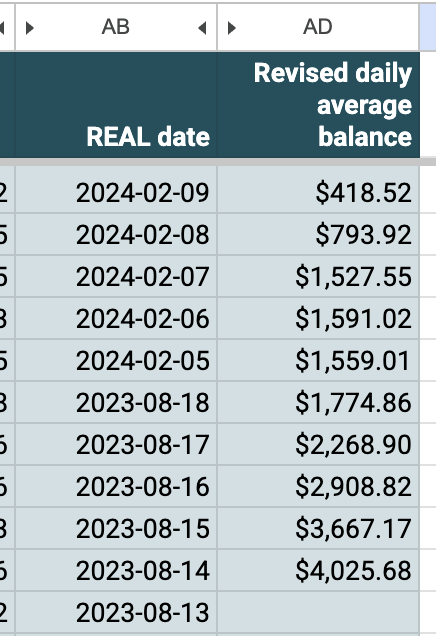 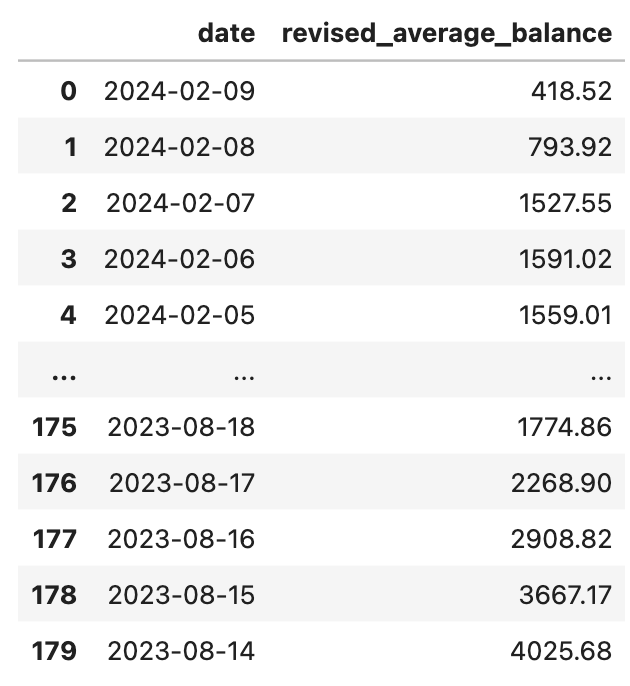

In [130]:
query = """
    SELECT SUM(revised_average_balance)
    FROM main.fct_daily_transactions_by_customer
"""
all_transactions_by_customer = run_query(query)
all_transactions_by_customer.head()

,sum(revised_average_balance)
0,654071.09


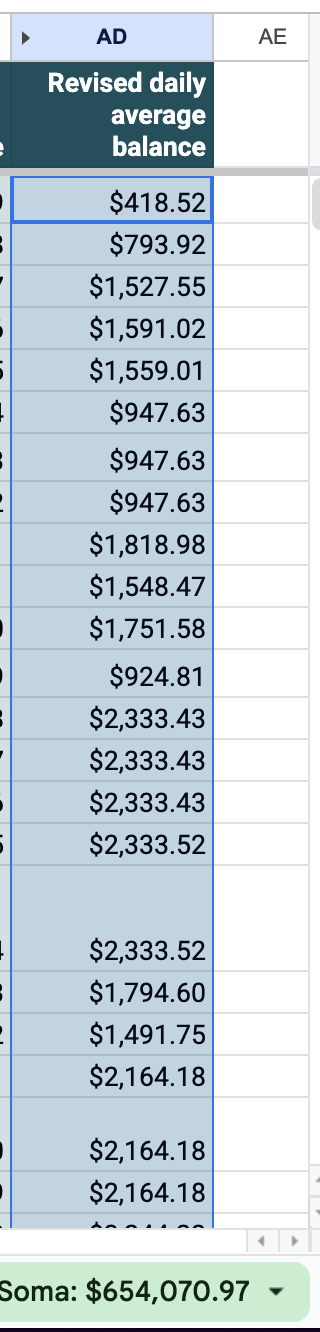

#### Modify Below

In [68]:
query = """
    SELECT
        username,
        email,
        request_id,
        request_datetime,
        date,
        withdrawals,
        deposits,
        balance
    FROM main.all_transactions_by_customer
"""
all_transactions_by_customer = run_query(query)
all_transactions_by_customer.head()

,username,email,request_id,request_datetime,date,withdrawals,deposits,balance
0,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,2024-02-06,107.34,NaN,1740.05
1,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,2024-01-31,268.86,NaN,1324.34
2,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,2024-01-29,5.30,NaN,1751.91
3,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,2024-01-29,312.77,NaN,333.17
4,Joel Schaubel,JOELSCHAUBEL@GMAIL.COM,727DAE61-63E9-4121-801E-F11CA8FF32FD,2024-02-11 19:26:39,2024-01-29,37.86,NaN,645.94


### Closing the Connection

In [33]:
con.close()
print("\nDatabase connection closed.") 


Database connection closed.
